<a href="https://colab.research.google.com/github/AdamKimhub/Msproject1/blob/main/model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

if "google.colab" in sys.modules:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    dataset_path = '/content/drive/My Drive/dataset'

    # Install required packages
    !pip install torch_geometric
    import torch
    from torch_geometric.data import Data, DataLoader

else:
    dataset_path = 'dataset'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.3 MB/s eta 0:00:00


## The data

In [2]:
# Load the data
# Training set
train_graphs = torch.load(f"{dataset_path}/combined/training.pt", weights_only=False)

# Validating set
val_graphs = torch.load(f"{dataset_path}/combined/validating.pt", weights_only=False)

# Testing set
test_graphs = torch.load(f"{dataset_path}/combined/testing.pt", weights_only=False)

In [3]:
# Create data loaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

## Build model

### import dependancies

In [4]:
# import dependancies
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, NNConv

In [5]:
# Model focused on structure only
class GNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super().__init__()
        # Edge NN maps edge_attr to weight matrix
        self.edge_nn = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, node_dim * hidden_dim)
        )

        self.conv1 = NNConv(node_dim, hidden_dim, self.edge_nn, aggr='mean')
        self.fc2 = nn.Linear(hidden_dim, 1)  # Regression output

    def forward(self, x, edge_index, edge_attr,):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.fc2(x)
        return x

In [ ]:
'''
# Model considering global attributes
class GNNModel(nn.Module):
    def __init__(self, node_dim, edge_dim, global_dim, hidden_dim):
        super().__init__()
        # Edge NN maps edge_attr to weight matrix
        self.edge_nn = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, node_dim * hidden_dim)
        )

        self.conv1 = NNConv(node_dim, hidden_dim, self.edge_nn, aggr='mean')
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn, aggr='mean')

        self.fc1 = nn.Linear(hidden_dim + global_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Regression output

    def forward(self, x, edge_index, edge_attr, batch, global_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)
        x = torch.cat([x, global_attr], dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
'''

"\n# Model considering global attributes\nclass GNNModel(nn.Module):\n    def __init__(self, node_dim, edge_dim, global_dim, hidden_dim):\n        super().__init__()\n        # Edge NN maps edge_attr to weight matrix\n        self.edge_nn = nn.Sequential(\n            nn.Linear(edge_dim, 32),\n            nn.ReLU(),\n            nn.Linear(32, node_dim * hidden_dim)\n        )\n\n        self.conv1 = NNConv(node_dim, hidden_dim, self.edge_nn, aggr='mean')\n        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn, aggr='mean')\n\n        self.fc1 = nn.Linear(hidden_dim + global_dim, hidden_dim)\n        self.fc2 = nn.Linear(hidden_dim, 1)  # Regression output\n\n    def forward(self, x, edge_index, edge_attr, batch, global_attr):\n        x = F.relu(self.conv1(x, edge_index, edge_attr))\n        x = F.relu(self.conv2(x, edge_index, edge_attr))\n        x = global_mean_pool(x, batch)\n        x = torch.cat([x, global_attr], dim=1)\n        x = F.relu(self.fc1(x))\n        return s

### model instance, optimizer, loss function

In [6]:
# Instantiate model, optimizer, loss

# run the model in the gpu if the device has one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instance of the model
model = GNNModel(node_dim=8, edge_dim=3, hidden_dim=32).to(device) # Without global features
# model = GNNModel(node_dim=8, edge_dim=3, global_dim=10, hidden_dim=32).to(device) # with global features


# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
loss_fn = nn.MSELoss()

### Train and validation loops

In [7]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        # out = model(data.x, data.edge_index, data.edge_attr, data.batch, data.u) # With global attributes
        out = model(data.x, data.edge_index, data.edge_attr) # Without global attributes
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

In [8]:
def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            # out = model(data.x, data.edge_index, data.edge_attr, data.batch, data.u) # With global attributes
            out = model(data.x, data.edge_index, data.edge_attr) # Without global attributes
            loss = loss_fn(out, data.y)
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [ ]:
### Training, validating, and testing

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([138, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([132, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([116, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Epoch 001, Train Loss: 10.6630, Val Loss: 0.4183


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([226, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([173, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Epoch 002, Train Loss: 0.3951, Val Loss: 0.3784


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([202, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([203, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([114, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Epoch 003, Train Loss: 0.3566, Val Loss: 0.3370


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([234, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([213, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 004, Train Loss: 0.3433, Val Loss: 0.3466


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([212, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([215, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

Epoch 005, Train Loss: 0.3363, Val Loss: 0.3216


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([95, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 006, Train Loss: 0.3308, Val Loss: 0.3614


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([228, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([101, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([204, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Epoch 007, Train Loss: 0.3311, Val Loss: 0.3360


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([98, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 008, Train Loss: 0.3290, Val Loss: 0.3166


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([227, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 009, Train Loss: 0.3237, Val Loss: 0.3167


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([224, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([232, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([233, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Epoch 010, Train Loss: 0.3219, Val Loss: 0.3166


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([220, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 011, Train Loss: 0.3208, Val Loss: 0.3391


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([241, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([94, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch 012, Train Loss: 0.3199, Val Loss: 0.3141
Epoch 013, Train Loss: 0.3168, Val Loss: 0.3135


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([240, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 014, Train Loss: 0.3166, Val Loss: 0.3132


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([230, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([255, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 015, Train Loss: 0.3163, Val Loss: 0.3138


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 016, Train Loss: 0.3163, Val Loss: 0.3135
Epoch 017, Train Loss: 0.3165, Val Loss: 0.3134


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([231, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 018, Train Loss: 0.3164, Val Loss: 0.3137


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 019, Train Loss: 0.3164, Val Loss: 0.3134


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([248, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([235, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

Epoch 020, Train Loss: 0.3161, Val Loss: 0.3132
Epoch 021, Train Loss: 0.3164, Val Loss: 0.3134
Epoch 022, Train Loss: 0.3165, Val Loss: 0.3133
Epoch 023, Train Loss: 0.3167, Val Loss: 0.3133


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([239, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([221, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 024, Train Loss: 0.3162, Val Loss: 0.3168


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([225, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 025, Train Loss: 0.3163, Val Loss: 0.3144


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([246, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 026, Train Loss: 0.3168, Val Loss: 0.3132
Epoch 027, Train Loss: 0.3165, Val Loss: 0.3143


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([45, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 028, Train Loss: 0.3166, Val Loss: 0.3135


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([252, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 029, Train Loss: 0.3164, Val Loss: 0.3133
Epoch 030, Train Loss: 0.3165, Val Loss: 0.3133


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 031, Train Loss: 0.3164, Val Loss: 0.3136
Epoch 032, Train Loss: 0.3166, Val Loss: 0.3133


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([238, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 033, Train Loss: 0.3164, Val Loss: 0.3135


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([38, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 034, Train Loss: 0.3169, Val Loss: 0.3133
Epoch 035, Train Loss: 0.3164, Val Loss: 0.3137
Epoch 036, Train Loss: 0.3165, Val Loss: 0.3139


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 037, Train Loss: 0.3167, Val Loss: 0.3133
Epoch 038, Train Loss: 0.3168, Val Loss: 0.3133


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([261, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 039, Train Loss: 0.3165, Val Loss: 0.3161


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([49, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 040, Train Loss: 0.3166, Val Loss: 0.3133
Test Loss: 0.3068


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


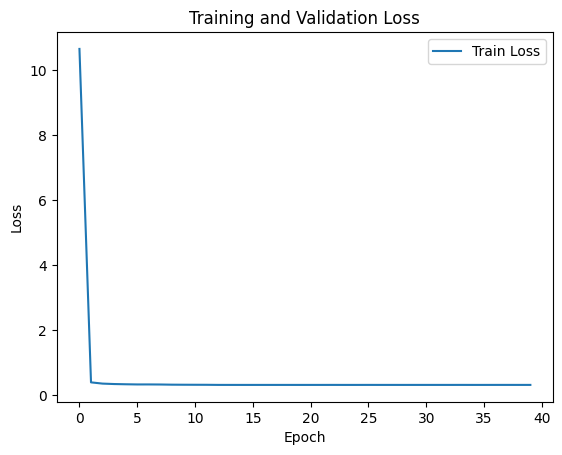

In [9]:
# Run training and testing
import matplotlib.pyplot as plt
train_losses = []
val_losses = []
for epoch in range(1, 41):
    train_loss = train()
    val_loss = evaluate(val_loader)
    print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

test_loss = evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Plotting the training and validation loss
plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
